# Non-stationary (actually piecewise stationary) version of the [SCM-MAB](https://papers.nips.cc/paper/2018/hash/c0a271bc0ecb776a094786474322cb82-Abstract.html) ('chronological causal bandit')

- Non-stationary (Bayesian) structural causal MAB
    - Non-stationary because the reward distributions shift across time
    - Bayesian because we have a prior on the reward distribution (sometimes, when we have enough data to start with)
    - Structural because we are aware of the causal structure of the reward distribution 

_Relation to causal Bayesian optimisation (BO)_: BO tells us _where_ on the selected arm to explore, bandits tell us _which_ arm to explore.

In [3]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
sys.path.append("../src")

In [22]:
from src.utils.dag_utils.graph_functions import make_graphical_model, make_networkx_object, get_time_slice_sub_graphs, make_time_slice_causal_diagrams
from npsem.scm_bandits import arms_of
from scipy.stats import bernoulli as ber
from src.examples.SEMs import testSEM
from src.examples.SEMs import DynamicIVCD
from src.examples.example_setup import setup_DynamicIVCD
from ccb import CCB

# Non-stationary SCM-MAB as piece-wise stationary SCM-MAB 

SCM-MAB will be run on the DAG in each time-slice (which could change across time). The reward distribution will change as we step through the graph, from left to right.

- We start with a DAG in which the connectivity is the same across time and then add complexity when it works.

In [5]:
node_info = {"Z": {"type": "manipulative", "domain": (0,1)},
             "X": {"type": "manipulative", "domain": (0,1)},
             "Y": {"type": "manipulative", "domain": (-1,1)}}
            #  "U" : {"type": "confounder"}}
# Constructor for adding unobserved confounder to graph
# XXX: this construction allows us to model situations in which confounding varibles appear and disappear across time-steps
conf_info = {0: ("X","Y"), 1:  ("X","Y"), 2:  ("X","Y")}

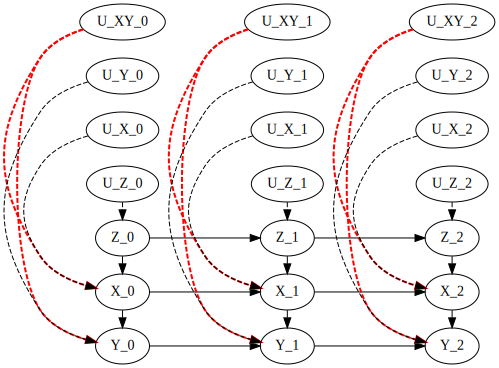

In [6]:
T = 3
graph_view = make_graphical_model(0,
T-1,
topology='dependent',
target_node='Y',
node_information= node_info,
confounder_info=conf_info,
verbose=True)
graph_view

In [7]:
background_info = {
    # Exogenous / background conditions
    "U_Z": {"type": "background", "domain": (0, 1)},
    "U_X": {"type": "background", "domain": (0, 1)},
    "U_Y": {"type": "background", "domain": (0, 1)},
    "U_XY": {"type": "confounder", "domain": (0, 1)},
}
# Contains all the sub-graphs per time-slice
G = make_networkx_object(graph_view, node_info | background_info, T)
# TODO: need to add assigned variable edges here but make sure that they are removed from the relevant node if that variable is intervened upon.
gs = get_time_slice_sub_graphs(G,T)
cds = make_time_slice_causal_diagrams(gs,conf_info)

## Explore SCM from fig 3

In [9]:
SEM = DynamicIVCD()
static = SEM.static()
dynamic = SEM.dynamic()

T = 3
N = 10
exo_vars = {"U_Z": ber.rvs(p=0.6, size=(N,T)), "U_X":ber.rvs(p=0.11, size=(N,T)), "U_Y":ber.rvs(p=0.15, size=(N,T)) ,"U_XY":ber.rvs(p=0.51, size=(N,T))}

In [13]:
from npsem.scm_bandits import SCM_to_bandit_machine, new_SCM_to_bandit_machine
from npsem.model import StructuralCausalModel
params = setup_DynamicIVCD()
m = CCB(**params)

# Get target for this time index
temporal_index = 0 # <----------------------
target = m.all_target_variables[temporal_index]
# Check that indices line up for this time-slice
target_var_only, target_var_temporal_index = target.split("_")
assert int(target_var_temporal_index) == temporal_index
SEM = testSEM()

# Create SCM
scm = StructuralCausalModel(
    G=m.causal_diagrams[temporal_index],
    F=SEM,
    P_U=m.P_U,
    D=m.domains,
    more_U=m.more_U,
)
print(m.arm_strategy)

#  Convert time-slice SCM to bandit machine
print("old")
mu, arm_setting = SCM_to_bandit_machine(scm, target_variable=target_var_only)
#  Select arm strategy, one of: "POMIS", "MIS", "Brute-force", "All-at-once"
arm_selected = arms_of(m.arm_strategy, arm_setting, scm.G, target_var_only)
print(mu, arm_setting, arm_selected)
print("new")
mu, arm_setting = new_SCM_to_bandit_machine(scm, reward_variable='Y')
#  Select arm strategy, one of: "POMIS", "MIS", "Brute-force", "All-at-once"
arm_selected = arms_of(m.arm_strategy, arm_setting, scm.G, target_var_only)
print(mu, arm_setting, arm_selected)

POMIS
old
(0.4454, 0.493, 0.5070000000000001, 0.773, 0.22700000000000004, 0.493, 0.493, 0.5070000000000001, 0.5070000000000001) {0: {}, 1: {'X': 0}, 2: {'X': 1}, 3: {'Z': 0}, 4: {'Z': 1}, 5: {'X': 0, 'Z': 0}, 6: {'X': 0, 'Z': 1}, 7: {'X': 1, 'Z': 0}, 8: {'X': 1, 'Z': 1}} (1, 2, 3, 4)
new
(0.4454, 0.493, 0.5070000000000001, 0.773, 0.22700000000000004, 0.493, 0.493, 0.5070000000000001, 0.5070000000000001) {0: {}, 1: {'X': 0}, 2: {'X': 1}, 3: {'Z': 0}, 4: {'Z': 1}, 5: {'X': 0, 'Z': 0}, 6: {'X': 0, 'Z': 1}, 7: {'X': 1, 'Z': 0}, 8: {'X': 1, 'Z': 1}} (1, 2, 3, 4)


In [11]:
temporal_index = 1 # <----------------------
target = m.all_target_variables[temporal_index]
# Check that indices line up for this time-slice
target_var_only, target_var_temporal_index = target.split("_")
assert int(target_var_temporal_index) == temporal_index
SEM = testSEM()

# Create SCM
scm = StructuralCausalModel(
    G=m.causal_diagrams[temporal_index],
    F=SEM,
    P_U=m.P_U,
    D=m.domains,
    more_U=m.more_U,
)

#  Convert time-slice SCM to bandit machine
past_interventions = [{"Z":0}]
mu, arm_setting = new_SCM_to_bandit_machine(scm, interventions=past_interventions, reward_variable=target_var_only)
# Select arm strategy, one of: "POMIS", "MIS", "Brute-force", "All-at-once"
arm_selected = arms_of(m.arm_strategy, arm_setting, scm.G, target_var_only)

print(mu, arm_setting, arm_selected)

(0.5518000000000002, 0.5490000000000003, 0.5546000000000002, 0.5518000000000002, 0.5518000000000003, 0.5490000000000003, 0.5490000000000003, 0.5546000000000002, 0.5546000000000002) {0: {}, 1: {'X': 0}, 2: {'X': 1}, 3: {'Z': 0}, 4: {'Z': 1}, 5: {'X': 0, 'Z': 0}, 6: {'X': 0, 'Z': 1}, 7: {'X': 1, 'Z': 0}, 8: {'X': 1, 'Z': 1}} (1, 2, 3, 4)


In [12]:
temporal_index = 2 # <----------------------
target = m.all_target_variables[temporal_index]
# Check that indices line up for this time-slice
target_var_only, target_var_temporal_index = target.split("_")
assert int(target_var_temporal_index) == temporal_index
SEM = testSEM()

# Create SCM
scm = StructuralCausalModel(
    G=m.causal_diagrams[temporal_index],
    F=SEM,
    P_U=m.P_U,
    D=m.domains,
    more_U=m.more_U,
)

#  Convert time-slice SCM to bandit machine
past_interventions = [{"Z":0}, {"Z":0}]
mu, arm_setting = new_SCM_to_bandit_machine(scm, interventions=past_interventions, reward_variable=target_var_only)
# Select arm strategy, one of: "POMIS", "MIS", "Brute-force", "All-at-once"
arm_selected = arms_of(m.arm_strategy, arm_setting, scm.G, target_var_only)

print(mu, arm_setting, arm_selected)

(0.5272222222222225, 0.525666666666667, 0.5287777777777779, 0.5272222222222225, 0.5272222222222225, 0.525666666666667, 0.525666666666667, 0.5287777777777779, 0.5287777777777779) {0: {}, 1: {'X': 0}, 2: {'X': 1}, 3: {'Z': 0}, 4: {'Z': 1}, 5: {'X': 0, 'Z': 0}, 6: {'X': 0, 'Z': 1}, 7: {'X': 1, 'Z': 0}, 8: {'X': 1, 'Z': 1}} (1, 2, 3, 4)


# Non-Stationary (piecewise stationary) SCM-MAB a.k.a. CCB

In [19]:
from src.examples.example_setup import setup_DynamicIVCD
from ccb import CCB

In [21]:
params = setup_DynamicIVCD(12)
m = CCB(**params)
m.run()

In [ ]:
m.reward_distribution